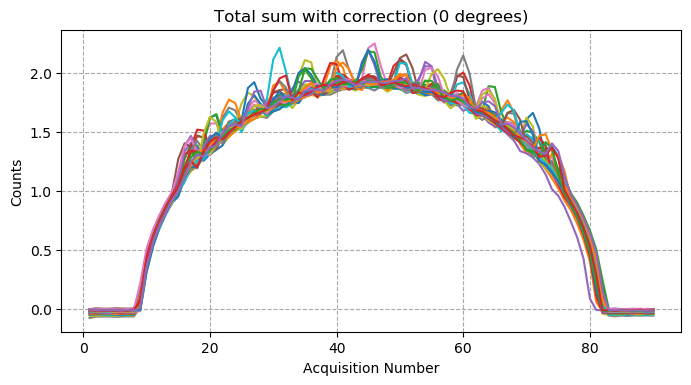

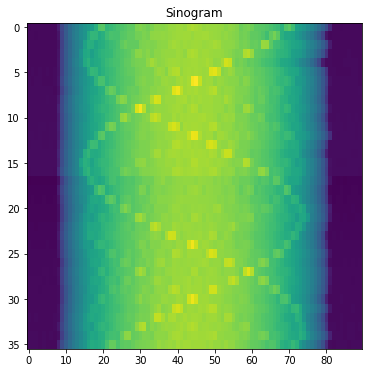

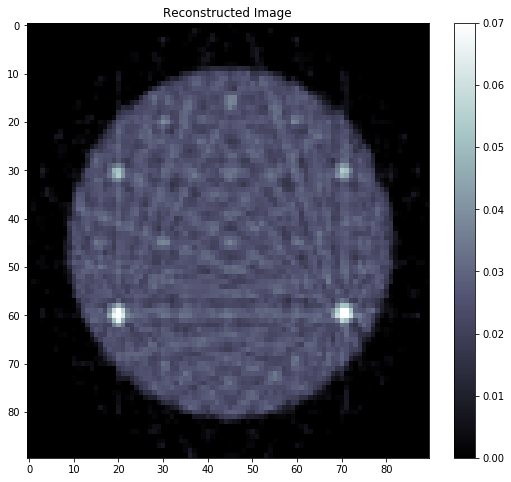

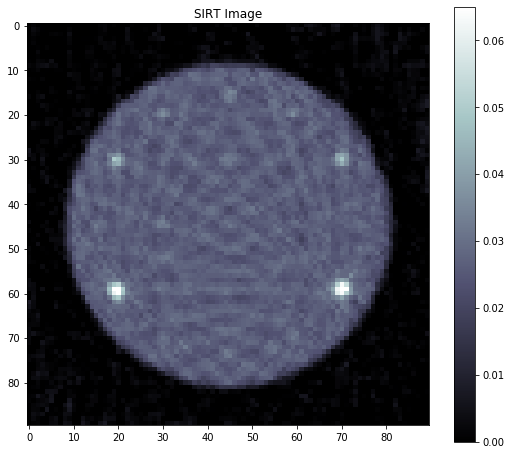

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from matplotlib.pyplot import figure
from skimage.transform import iradon
import astra

#Air scan
airscan_counts= sum(genfromtxt("Desktop/CT imaging/27-5-2021/air_scan.mca", skip_header=12,skip_footer=71))

tot_counts=[]
avg_counts=[]
for i in np.arange(0,360,10):
    for j in np.arange(1,91):
        counts = genfromtxt("Desktop/CT imaging/27-5-2021/angle_{:d}_acq_{:02d}.mca".format(i,j), skip_header=12,skip_footer=71)
        avg_counts.append(-np.log(sum(counts)/airscan_counts))
        counts=0
    tot_counts.append(avg_counts)
    avg_counts=[]

    
x= np.arange(1,91)

tot_counts=np.array(tot_counts)
for i in np.arange(0,35):
    figure(1,figsize=(8, 4), dpi=100)
    plt.plot(x,tot_counts[i])
    plt.xlabel('Acquisition Number')
    plt.ylabel('Counts')
    plt.title('Total sum with correction (0 degrees)')
    plt.grid(color='darkgrey',linestyle='--')

#sinogram
figure(2,figsize=(6,6))
plt.imshow(tot_counts,aspect='auto')
plt.title('Sinogram')

tot_counts=np.transpose(tot_counts)
#image reconstruction
theta=np.arange(0,360,10)
image=iradon(tot_counts,theta=theta)
figure(3,figsize=(9,8))
plt.imshow(image,aspect='auto',cmap='bone')
plt.colorbar()
plt.title('Reconstructed Image')
plt.clim(0,0.07)

#create geometries and projector
proj_geom = astra.create_proj_geom('parallel', 1,90, np.arange(0,2*np.pi,np.pi/18));
vol_geom = astra.create_vol_geom(90,90);
sinogram = astra.data2d.create('-sino',proj_geom,np.transpose(tot_counts));
recon_id = astra.data2d.create('-vol', vol_geom,data=iradon(tot_counts,theta=theta))
proj_id= astra.create_projector('line',proj_geom,vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = recon_id
cfg['ProjectionDataId'] = sinogram
cfg['ProjectorId']=proj_id
# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 100)

# Get the result
rec3 = astra.data2d.get(recon_id)
figure(8,figsize=(9,8))
plt.imshow(rec3,cmap='bone')
plt.colorbar()
plt.title('SIRT Image')
plt.clim(0,0.065)


# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(recon_id)
astra.projector.delete(proj_id)